## LDA - Linear Discriminant  Analysis

In [16]:
import csv
import numpy as np
import matplotlib.pyplot as plt

from numpy.linalg import eig
from scipy.linalg import inv

%matplotlib notebook

In [17]:
def ellipse(sigma, mean, scale=1):
    
    d, v = eig(inv(sigma))
    mat = v @ inv(np.sqrt(np.diag(d)))

    N = 200
    t = np.arange(0, N) * (2*np.pi) / N

    Y1 = scale * np.cos(t)
    Y2 = scale * np.sin(t)
   
    Y = np.array([Y1, Y2])

    X = mat @ Y

    X1 = X[0]
    X2 = X[1]

    # move ellipse to mean_k
    X1 = X1 + mean[0]
    X2 = X2 + mean[1]
    
    return X1, X2

In [18]:
def plot(samples, parameters):

    sam_a = samples["a"]
    sam_o = samples["o"]
    sam_u = samples["u"]

    data = (sam_a.T, sam_o.T, sam_u.T)
    colors = ("red", "green", "blue")
    groups = ("a", "o", "u")
    scales = (2, 2, 2)

    # Create plot
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    for data, color, group in zip(data, colors, groups):
        x, y = data
        ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

    for color, group, scale in zip(colors, groups, scales):
        X1, X2 = ellipse(parameters["sigma"][group], parameters["mean"][group], scale=scale)
        ax.plot(X1, X2, c=color)
    
    plt.title('LDA - A,O,U')
    plt.legend(loc=2)
    plt.show()

In [34]:
def parse():

    # parse data
    with open('a.txt') as f:
        lines_a = list(csv.reader(f, delimiter='\t'))

    with open('o.txt') as f:
        lines_o = list(csv.reader(f, delimiter='\t'))

    with open('u.txt') as f:
        lines_u = list(csv.reader(f, delimiter='\t'))

    lines_a = list(map(lambda x: [int(x[0]), int(x[1])],lines_a))
    lines_o = list(map(lambda x: [int(x[0]), int(x[1])],lines_o))
    lines_u = list(map(lambda x: [int(x[0]), int(x[1])],lines_u))

    # separate 'train' and 'test' datasets
    train_a = np.array(lines_a[:34])
    test_a = np.array(lines_a[35:])
    
    train_o = np.array(lines_o[:34])
    test_o = np.array(lines_o[35:])
    
    train_u = np.array(lines_u[:34])
    test_u = np.array(lines_u[35:])

    x_tot = len(train_a) + len(train_o) + len(train_u)

    # mean calc
    mean_a = np.mean(train_a, axis=0)
    mean_o = np.mean(train_o, axis=0)
    mean_u = np.mean(train_u, axis=0)
    
    sigma_a = np.cov(train_a, rowvar=False)
    sigma_o = np.cov(train_o, rowvar=False)
    sigma_u = np.cov(train_u, rowvar=False)

   
    # plot
    samples = {
        "a": train_a,
        "o": train_o,
        "u": train_u
    }
    
    tests = {
        "a": test_a,
        "o": test_o,
        "u": test_u
    }
    
    parameters = {
        "mean": {
            "a": mean_a,
            "o": mean_o,
            "u": mean_u
        },
        "sigma": {
            "a": sigma_a,
            "o": sigma_o,
            "u": sigma_u,
        }
    }
    
    return samples, tests, parameters

In [35]:
data, tests, parameters = parse()

### LDA classification

In [36]:
def clasify(test, ga, go, gu, which):

    positive = 0

    for sample in test:
        
        predictions = [(ga(sample), "a"), (go(sample), "o"), (gu(sample), "u")]
        prob, k = max(predictions, key=lambda x: x[0])
        
        if k == which:
            positive += 1

    return positive

In [39]:
# sigma calc
sigma = (parameters["sigma"]["a"] + parameters["sigma"]["o"] + parameters["sigma"]["u"]) / 3
sigma_inv = inv(sigma).T

# means
mean_a = parameters["mean"]["a"]
mean_o = parameters["mean"]["o"]
mean_u = parameters["mean"]["u"]

# data sets
train_a = data["a"]
train_o = data["o"]
train_u = data["u"]
test_a = tests["a"]
test_o = tests["o"]
test_u = tests["u"]

x_tot = len(train_a) + len(train_o) + len(train_u)

# w1
w1a = sigma_inv @ mean_a.T
w1o = sigma_inv @ mean_o.T
w1u = sigma_inv @ mean_u.T

# w0
w0a = (-0.5) * mean_a @ sigma_inv @ mean_a.T + np.log(len(train_a)/x_tot)
w0o = (-0.5) * mean_o @ sigma_inv @ mean_o.T + np.log(len(train_o)/x_tot)
w0u = (-0.5) * mean_u @ sigma_inv @ mean_u.T + np.log(len(train_u)/x_tot)

# function g calc
ga = lambda x: w1a @ x + w0a
go = lambda x: w1o @ x + w0o
gu = lambda x: w1u @ x + w0u     

positive_a = clasify(test_a, ga, go, gu, "a")
positive_o = clasify(test_o, ga, go, gu, "o")
positive_u = clasify(test_u, ga, go, gu, "u")

print("Test for A - accuracy: {}".format(positive_a/len(test_a)))
print("Test for O - accuracy: {}".format(positive_o/len(test_o)))
print("Test for U - accuracy: {}".format(positive_u/len(test_u)))


Test for A - accuracy: 0.9333333333333333
Test for O - accuracy: 1.0
Test for U - accuracy: 0.9333333333333333


### Plotting

<IPython.core.display.Javascript object>


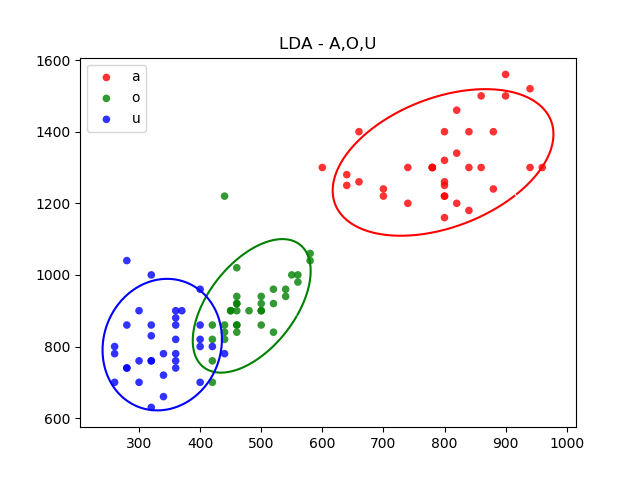

In [38]:
plot(data, parameters)